In [1]:
# Initialize Modules

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy 
import sys 
import os
import pickle
import librosa
import librosa.display
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential

/var/folders/jk/ts1fwrbn15919mczqmg6fxrm0000gn/T/ipykernel_91525/2482089664.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Data Processing

In [2]:
# Load Dataset
df = pd. read_csv("./data/features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [3]:
# Cleaning Data
df=df.drop(labels="filename", axis=1)

### Feature Extraction

Preprocessing of data is required before we finally train the data. We will try and focus on the last column that is ‘label’ and will encode it with the function LabelEncoder() of sklearn.preprocessing.

In [4]:
class_list=df.iloc[:,-1]
converter = LabelEncoder()

In [5]:
y=converter.fit_transform(class_list)
y

array([0, 0, 0, ..., 9, 9, 9])

In [6]:
# Saving Classification Converter
pickle.dump(converter, open("./model/classes.pkl", "wb"))

In [7]:
# Scaling the Features
fit = StandardScaler()
X = fit.fit_transform(np.array(df.iloc[:,:-1],dtype=float))
X

array([[ 0.        , -0.48780784,  0.64052047, ..., -0.51356204,
         0.12841417, -0.29178072],
       [ 0.        , -0.40314187,  0.13183473, ...,  1.01138445,
         1.27578001,  0.05642464],
       [ 0.        , -0.36169428,  0.7644909 , ..., -0.04624405,
         0.65390663, -0.52145798],
       ...,
       [ 0.        , -0.35433044,  0.42997426, ..., -0.15370124,
         0.11765485, -0.33882395],
       [ 0.        ,  0.0883611 , -0.00630133, ..., -0.72456977,
         0.30333409, -0.95893743],
       [ 0.        , -0.11321002,  0.19536324, ..., -0.37245283,
        -0.47495901, -0.55112155]])

In [8]:
# Saving Scalar
pickle.dump(fit, open("./model/scaler.pkl", "wb"))

In [9]:
# Creating Train/Test Split

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33)
print("Amount to Train: ", len(y_train))
print("Amount to Test: ", len(y_test))

Amount to Train:  6693
Amount to Test:  3297


### Model Building

In [10]:
def train_model(model,epochs,optimizer):
    batch_size=128
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics='accuracy')
    return model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

def plot_validate(history):
    print("Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [11]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(512,activation='relu',input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(10,activation='softmax'),
])

print(model.summary())
model_history=train_model(model=model,epochs=600,optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

Validation Accuracy 0.9366090297698975


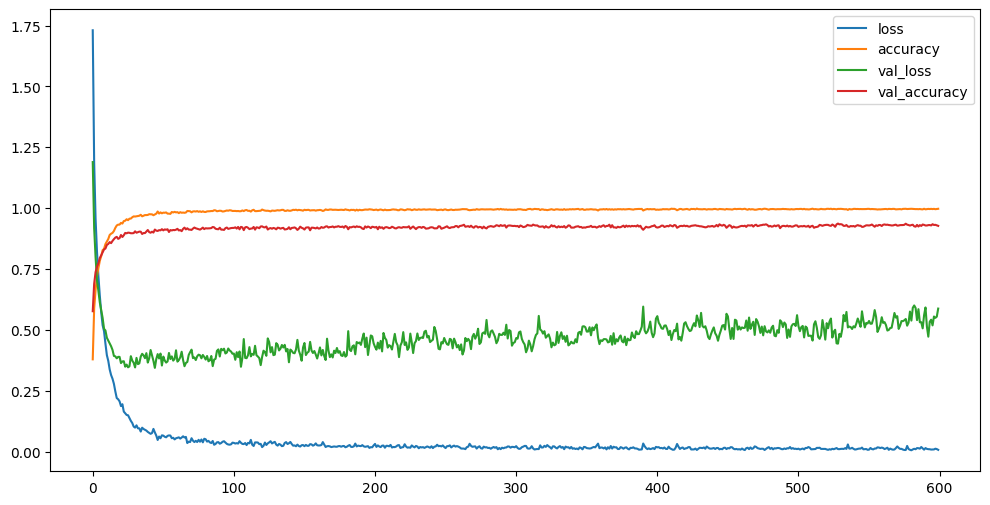

In [12]:
plot_validate(model_history)

In [13]:
# Saving Model for Use
model.save('./model/model.keras')

### Model Evaluation

In [14]:
test_loss,test_acc=model.evaluate(X_test, y_test, batch_size=128)
print("The test loss is ", test_loss)
print("The best accuracy is: ", test_acc*100)

26/26 [==============================] - 0s 2ms/step - loss: 0.5874 - accuracy: 0.9272
The test loss is  0.5874032378196716
The best accuracy is:  92.72065758705139
